In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np
import tensorflow_model_optimization as tfmot

set_seed(1234)

2023-08-15 21:54:38.668935: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 21:54:38.872260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:54:39.771988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [10]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
# radioml_ds.load(dataset_path, expand2d=True)
radioml_ds.load(dataset_path, expand2d=False)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(f"Modulations: {radioml_ds.get_modulations()}")

{'8PSK': 0, 'AM-DSB': 1, 'BPSK': 2, 'CPFSK': 3, 'GFSK': 4, 'PAM4': 5, 'QAM16': 6, 'QAM64': 7, 'QPSK': 8, 'WBFM': 9}
Modulations: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


# Create Model
Create convolutional model

In [12]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml16b_q_aware"
train_model = True
q_aware = False

quantize_model = tfmot.quantization.keras.quantize_model

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        # input_shape=(1, 128, 2),
        input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        output_channels=[32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8],
        paddings=["same", "same", "same", "same",],
        max_pool_sizes=[1, 2, 2, 1],
        max_pool_strides=[1, 2, 2, 1],
        avg_size=32,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    # model = make_sigmod_model(ModelName.CNN_1D_V013, model_configuration)
    model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

    model.summary()

else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]
    
if q_aware:
    print("Model is quantization aware")
    model = quantize_model(model)
else:
    print("Model is NOT quantization aware")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN0_ (Conv1D)              (None, 128, 32)           544       
                                                                 
 MAX_POOL_0_ (MaxPooling1D)  (None, 128, 32)           0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 128, 32)           128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 128, 32)           0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 48)           12336     
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 64, 48)            0   

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [13]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


if train_model:
    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16
    # N_EPOCHS = 48
    N_EPOCHS = 20
    # N_EPOCHS = 7
    BATCH_SIZE = 256

    h = model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
        callbacks=[lrate]
    )


Epoch 1/20


2023-08-15 22:01:51.933263: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  12/3750 [..............................] - ETA: 17s - loss: 2.3023 - accuracy: 0.1130    

2023-08-15 22:01:52.155536: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3750/3750 [==============================] - 21s 5ms/step - loss: 1.4695 - accuracy: 0.4111 - val_loss: 1.2382 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 2/20
3750/3750 [==============================] - 20s 5ms/step - loss: 1.1263 - accuracy: 0.5238 - val_loss: 1.0774 - val_accuracy: 0.5482 - lr: 0.0010
Epoch 3/20
3750/3750 [==============================] - 20s 5ms/step - loss: 1.0545 - accuracy: 0.5545 - val_loss: 1.0383 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/20
3750/3750 [==============================] - 20s 5ms/step - loss: 1.0237 - accuracy: 0.5672 - val_loss: 1.0087 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 5/20
3750/3750 [==============================] - 20s 5ms/step - loss: 1.0048 - accuracy: 0.5752 - val_loss: 1.0137 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 6/20
3750/3750 [==============================] - 21s 6ms/step - loss: 0.9949 - accuracy: 0.5793 - val_loss: 0.9915 - val_accuracy: 0.5816 - lr: 0.0010
Epoch 7/20
3750/3750 [==============================] - 21s 5ms

# Evaluation
Check train plots, confusion matrices, snr to accuracy

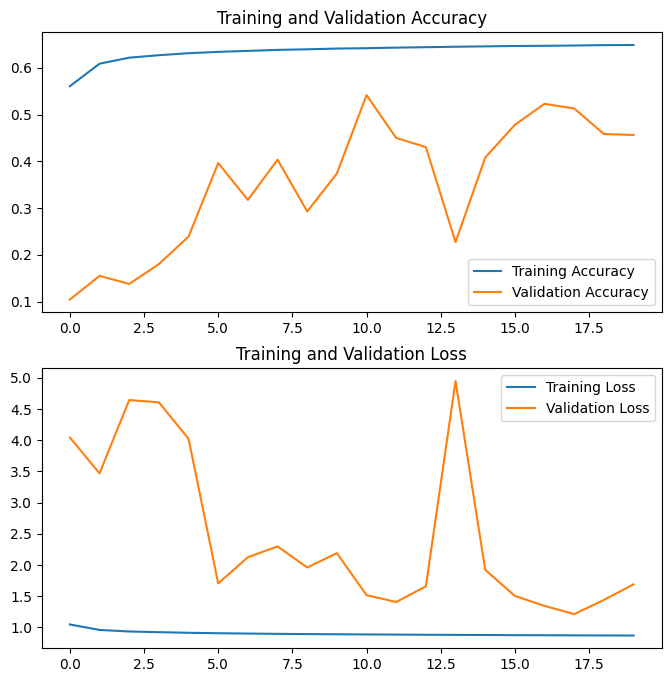

In [6]:
if train_model:
    from evaluation.vizualization import plot_train, plot_snr_to_acc
    plot_train(h.history)

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.45574166666666666}
8PSK test accuracy: 0.2584679089026915
AM-DSB test accuracy: 0.2781936332976886
BPSK test accuracy: 0.6236254581806064
CPFSK test accuracy: 0.6035752710419597
GFSK test accuracy: 0.6616952522992792
PAM4 test accuracy: 0.5899840884348044
QAM16 test accuracy: 0.5150470746469401
QAM64 test accuracy: 0.15660048184763645
QPSK test accuracy: 0.5540852044736617
WBFM test accuracy: 0.32216216216216215
Confusion matrix:
[[3121  162  847  407 2422    8 2902   74 1194  938]
 [   1 3382 3477  120 1976    0    0    0  724 2477]
 [  45  189 7486  268 2219  396   24   18  474  885]
 [  34  162  707 7293 2523    1   24    6  424  909]
 [ 172  456  575  113 7986    0    0    0  283 2484]
 [  29  191 1779  243 1628 7045   45   26  261  694]
 [ 510  146  584  356 1646   14 6127 1158  749  606]
 [ 491  102  408  321 1205   18 6558 1885  646  403]
 [ 298  162  850  378 2298    3  327   44 6490  863]
 [  10 2400 2913  126 2175

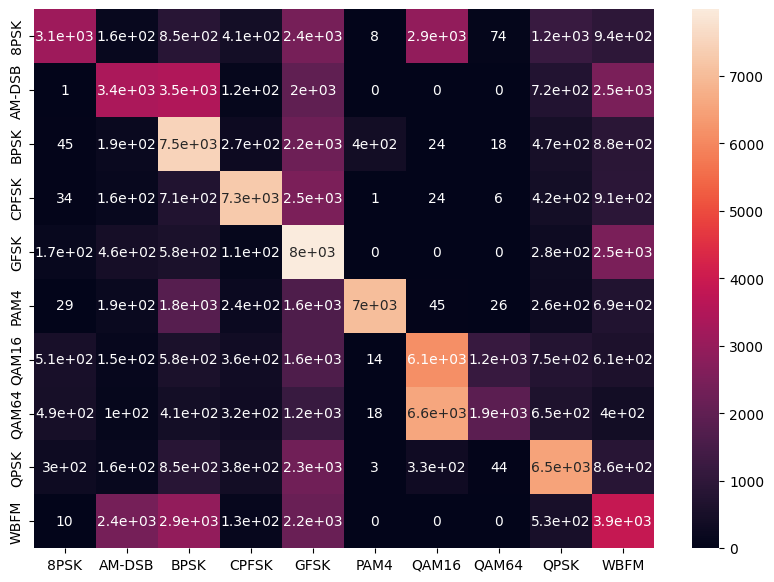

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.4565916666666667}
8PSK test accuracy: 0.2549198704641701
AM-DSB test accuracy: 0.28607047872340424
BPSK test accuracy: 0.6283273903308733
CPFSK test accuracy: 0.6070417845846512
GFSK test accuracy: 0.6497414596931423
PAM4 test accuracy: 0.6008291873963516
QAM16 test accuracy: 0.5234519993251223
QAM64 test accuracy: 0.16084145043791437
QPSK test accuracy: 0.540948096309256
WBFM test accuracy: 0.321701199563795
Confusion matrix:
[[3070  169  892  410 2443    1 2833  107 1154  964]
 [   6 3442 3474  107 1895    2    0    0  680 2426]
 [  40  205 7577  241 2164  365   14   17  494  942]
 [  26  186  696 7293 2511    0   15    4  394  889]
 [ 178  444  560  122 7665    0    0    0  280 2548]
 [  32  210 1641  250 1688 7246   39   40  264  650]
 [ 478  131  560  335 1604   16 6205 1224  737  564]
 [ 517  105  394  300 1239   20 6629 1965  666  382]
 [ 284  161  916  378 2443    4  367   47 6493  910]
 [   5 2347 3009  124 2144   

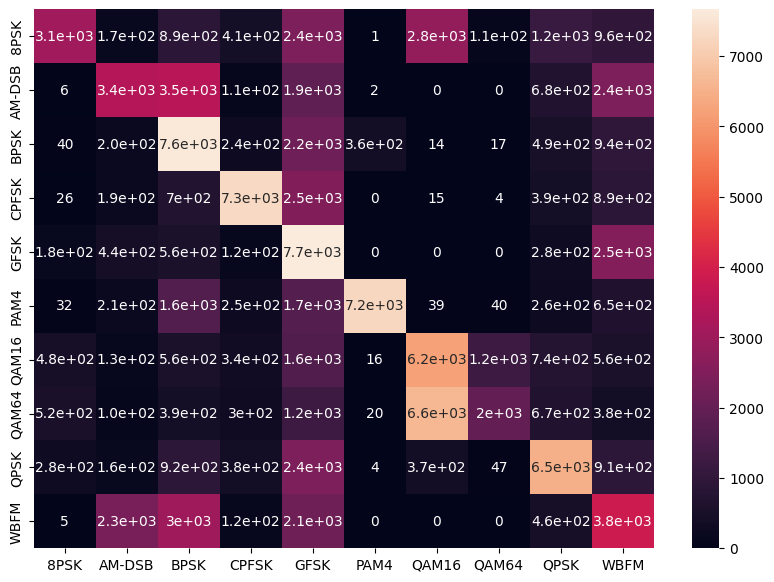

In [7]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.1052979039445453
SNR: -18 -- Overall test accuracy: 0.09441489361702128
SNR: -16 -- Overall test accuracy: 0.10031873846670022
SNR: -14 -- Overall test accuracy: 0.10459269192088501
SNR: -12 -- Overall test accuracy: 0.11560789517332891
SNR: -10 -- Overall test accuracy: 0.1467935871743487
SNR: -8 -- Overall test accuracy: 0.27
SNR: -6 -- Overall test accuracy: 0.42299864314789687
SNR: -4 -- Overall test accuracy: 0.5828210666223625
SNR: -2 -- Overall test accuracy: 0.6306038047973532
SNR: 0 -- Overall test accuracy: 0.6275189957053188
SNR: 2 -- Overall test accuracy: 0.6337180130456598
SNR: 4 -- Overall test accuracy: 0.6471171320006608
SNR: 6 -- Overall test accuracy: 0.6558452481076535
SNR: 8 -- Overall test accuracy: 0.6602086438152012
SNR: 10 -- Overall test accuracy: 0.6680477295326483
SNR: 12 -- Overall test accuracy: 0.6471489361702127
SNR: 14 -- Overall test accuracy: 0.6612258494337109
SNR: 16 -- Overall test accuracy: 0.6724627988630664
S

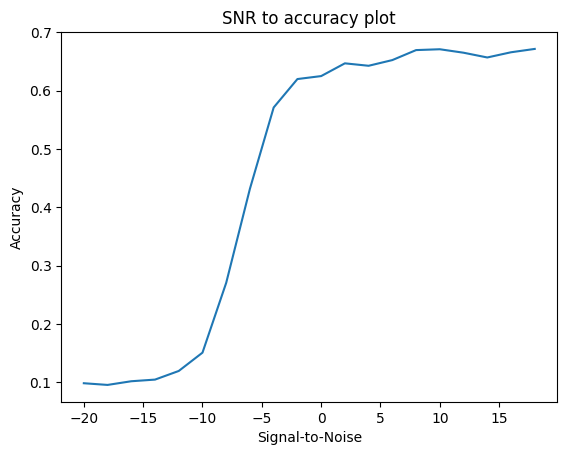

In [8]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_val)

# Save results

In [9]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))
# history = {}

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

In [12]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)



INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_q_aware_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_q_aware_results/model_original/assets
2023-08-14 01:14:19.917850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-14 01:14:19.917878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-14 01:14:19.918030: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_q_aware_results/model_original
2023-08-14 01:14:19.922585: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-14 01:14:19.922600: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_q_aware_results/model_original
2023-08-14 01:14:19.937080: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-14 01:14:20.050885: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [14]:
# cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_modulations(),
#     predict_func=predict_tflite,
# )

reload_module("evaluation.metric_evaluation")
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation


snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

SNR: 18 -- Overall test accuracy: 0.6658411754994221
SNR: 16 -- Overall test accuracy: 0.6646045811737168
SNR: 14 -- Overall test accuracy: 0.6578947368421053


In [10]:
# reload_module("deployment_tools")
from deployment_tools import to_tf_lite, predict_tflite

representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

NameError: name 'model_path' is not defined

In [13]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0])

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   2], dtype=int32), 'shape_signature': array([ -1, 128,   2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0004541363741736859, -4), 'quantization_parameters': {'scales': array([0.00045414], dtype=float32), 'zero_points': array([-4], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 53, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


0it [00:00, ?it/s]

11it [00:00, 1542.02it/s]
